In [1]:
# import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
# ignore warnings   
import warnings
warnings.filterwarnings('ignore')

In [14]:
# import the df_titanic_modifiedset into pandas df_titanic_modifiedframe
df_titanic_train = pd.read_csv('train.csv')

print(df_titanic_train.info())  # Get an overview of the df_titanic_modified types and missing values
# print(df_titanic.describe())  # Summary statistics for numerical features

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [15]:
print(df_titanic_train.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


<Axes: >

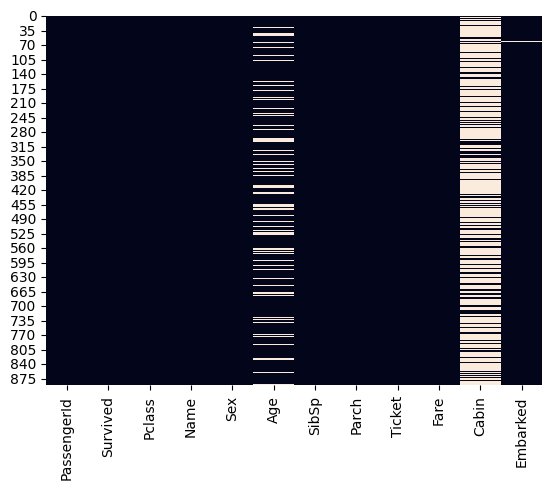

In [16]:
# perform EDA and df_titanic_modified cleaning
print(df_titanic_train.isnull().sum())

# plot the null values
sns.heatmap(df_titanic_train.isnull(), cbar=False)

In [17]:
# print(df_titanic_train['Age'].value_counts())

# make a copy of the df_titanic_modifiedframe for the modification
df_titanic_modified = df_titanic_train.copy()

thershhold = len(df_titanic_modified) * 0.05  # the threshold for drop nan
print(f"the thershhold for drop nan: ", {thershhold})

# dealing with nan in the Fare column
fare_mean = df_titanic_modified['Fare'].mean().round(2)
print(fare_mean)
df_titanic_modified['Fare'] = df_titanic_modified['Fare'].fillna(fare_mean)
print(f"the fare nan count: ", {df_titanic_modified['Fare'].isna().sum()})

# dealing with nan in the Age column
Age_mean = df_titanic_modified['Age'].mean()
Age_median = df_titanic_modified['Age'].median()
Age_mode = df_titanic_modified['Age'].mode().values[0]  # mode() returns a Series, so we need to get the value

# printing the mean, median, and mode of the age column
print(f"Mean: {Age_mean}, Median: {Age_median}, Mode: {Age_mode}")
df_titanic_modified['Age'] = df_titanic_modified['Age'].fillna(Age_median)

df_titanic_modified.drop(columns=['Cabin'], inplace=True)

embark_mode = df_titanic_modified['Embarked'].mode() 
print(f"Embark_Mode: {embark_mode}")
df_titanic_modified['Embarked'] = df_titanic_modified['Embarked'].fillna(embark_mode[0])

print(df_titanic_modified.isna().sum())

the thershhold for drop nan:  {44.550000000000004}
32.2
the fare nan count:  {np.int64(0)}
Mean: 29.69911764705882, Median: 28.0, Mode: 24.0
Embark_Mode: 0    S
Name: Embarked, dtype: object
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


In [18]:
# encode categorical variables

df_titanic_modified['Embarked'] = df_titanic_modified['Embarked'].astype('category')

df_titanic_modified['Sex'] = df_titanic_modified['Sex'].map({'male': 0, 'female': 1})

df_titanic_modified = pd.get_dummies(df_titanic_modified, columns=['Embarked'], dtype='int')

print(df_titanic_modified[['Survived', 'Pclass', 'Sex', 'Embarked_C', 'Embarked_Q', 'Embarked_S']].head())
# PassengerId Survived Pclass Name Sex Age SibSp Parch Ticket Fare Cabin Embarked
# df_titanic_modified.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True

   Survived  Pclass  Sex  Embarked_C  Embarked_Q  Embarked_S
0         0       3    0           0           0           1
1         1       1    1           1           0           0
2         1       3    1           0           0           1
3         1       1    1           0           0           1
4         0       3    0           0           0           1


In [19]:
# data preprocessing and feature engineering
df_titanic_modified['FamilySize'] = df_titanic_modified['SibSp'] + df_titanic_modified['Parch'] + 1

df_titanic_modified['Title'] = df_titanic_modified['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
# print(df_titanic_modified['Title'].value_counts())

def map_title(title):
    if title == 'Mr':
        return 1
    elif title == 'Miss':
        return 2
    elif title == 'Mrs':
        return 3
    elif title == 'Master':
        return 4
    else:
        return 5

df_titanic_modified['Title'] = df_titanic_modified['Title'].apply(map_title)


print(df_titanic_modified[['Title', 'Survived']].groupby(['Title'], as_index=False).mean())

   Title  Survived
0      1  0.156673
1      2  0.697802
2      3  0.792000
3      4  0.575000
4      5  0.444444


In [20]:
df_titanic_modified.drop(['Ticket', 'PassengerId', 'SibSp', 'Parch', 'Name'], axis=1, inplace=True)
print(df_titanic_modified.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Sex         891 non-null    int64  
 3   Age         891 non-null    float64
 4   Fare        891 non-null    float64
 5   Embarked_C  891 non-null    int64  
 6   Embarked_Q  891 non-null    int64  
 7   Embarked_S  891 non-null    int64  
 8   FamilySize  891 non-null    int64  
 9   Title       891 non-null    int64  
dtypes: float64(2), int64(8)
memory usage: 69.7 KB
None


Survived
0    549
1    342
Name: count, dtype: int64


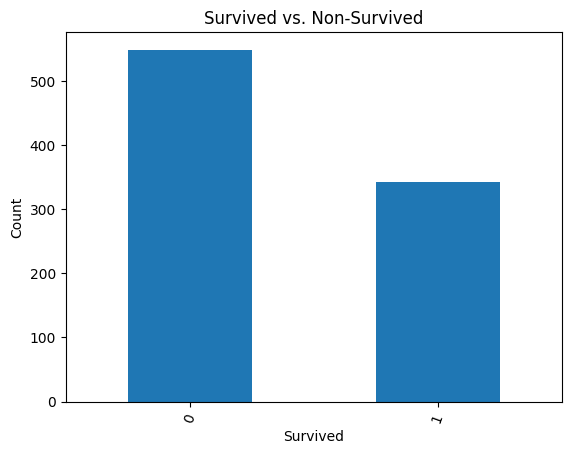

In [21]:
df_titanic_modified['Survived'].value_counts().plot(kind='bar')
plt.title('Survived vs. Non-Survived')
plt.xlabel('Survived')
plt.ylabel('Count')
plt.xticks(rotation=70)
print(df_titanic_modified['Survived'].value_counts())

In [22]:
# split the df_titanic_modifiedset into train and test sets
X = df_titanic_modified.drop('Survived', axis=1)
y = df_titanic_modified['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# print the shapes of the train and test sets
# print(X_train.shape)
# print(y_train.shape)
# print(X_test.shape)
# print(y_test.shape)

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print(X_resampled.shape, y_resampled.shape)
# Optional: Standardize the features
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)
X_test = scaler.transform(X_test)

(784, 9) (784,)


In [23]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

CV = cross_val_score(logreg, X_train, y_train, cv=5)
print(f"Cross-Validation Score: {CV}")
print(f"Mean Cross-Validation Score: {CV.mean()}")

y_pred = logreg.predict(X_test)
print(f"Accuracy Score: {accuracy_score(y_test, y_pred)}")
print(f"Confusion Matrix: \n {confusion_matrix(y_test, y_pred)}")
print(f"F1 Score: {f1_score(y_test, y_pred)}")
print(f"Precision Score: {precision_score(y_test, y_pred)}")
print(f"Recall Score: {recall_score(y_test, y_pred)}")

Cross-Validation Score: [0.784      0.888      0.768      0.79032258 0.84677419]
Mean Cross-Validation Score: 0.8154193548387096
Accuracy Score: 0.7686567164179104
Confusion Matrix: 
 [[116  41]
 [ 21  90]]
F1 Score: 0.743801652892562
Precision Score: 0.6870229007633588
Recall Score: 0.8108108108108109


In [24]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_resampled, y_resampled)

CV = cross_val_score(rfc, X_resampled, y_resampled, cv=5)
print(f"Cross-Validation Score: {CV}")
print(f"Mean Cross-Validation Score: {CV.mean()}")

y_pred = rfc.predict(X_test)
print(f"Accuracy Score: {accuracy_score(y_test, y_pred)}")
print(f"Confusion Matrix: \n {confusion_matrix(y_test, y_pred)}")
print(f"F1 Score: {f1_score(y_test, y_pred)}")
print(f"Precision Score: {precision_score(y_test, y_pred)}")
print(f"Recall Score: {recall_score(y_test, y_pred)}")


Cross-Validation Score: [0.8089172  0.77070064 0.84713376 0.87898089 0.8525641 ]
Mean Cross-Validation Score: 0.831659317328107
Accuracy Score: 0.7835820895522388
Confusion Matrix: 
 [[129  28]
 [ 30  81]]
F1 Score: 0.7363636363636363
Precision Score: 0.7431192660550459
Recall Score: 0.7297297297297297
